# Supervised Forward-Forward on MNIST
**Importing Libraries**

In [ ]:
import torch
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Lambda, Normalize, GaussianBlur
from tqdm import tqdm
from typing import List

**Setting Default Parameters**

In [ ]:
plt.rc('image', cmap='gray')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


**Loading the Dataset**

In [ ]:
transform = Compose([
        ToTensor(),
        Lambda(lambda x: torch.flatten(x))])

train_data = MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)
train_set, val_set = torch.utils.data.random_split(train_data, [50000, 10000])
test_set = MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 9912422/9912422 [00:00<00:00, 119967887.66it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 72579804.57it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48088469.97it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5499575.28it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



**Implementing the FF Layer**

In [ ]:
class FFLayer(torch.nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.activation = torch.nn.ReLU()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000
        self.val_losses = []

    def forward(self, x):
        x_normalized = x / (x.norm(2, 1, keepdim=True) + 1e-8)
        return self.activation(torch.mm(x_normalized, self.weight.T) + self.bias.unsqueeze(0))

    def train(self, train_p, train_n, val_p, val_n):
        self.val_losses = []
        for i in range(self.num_epochs):
            gtp = self.forward(train_p).pow(2).mean(1)
            gtn = self.forward(train_n).pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([-gtp + self.threshold, gtn - self.threshold]))).mean()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            gvp = self.forward(val_p).pow(2).mean(1)
            gvn = self.forward(val_n).pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([-gtp + self.threshold, gtn - self.threshold]))).mean()
            self.val_losses.append(loss.item())

        return self.forward(train_p).detach(), self.forward(train_n).detach(), self.forward(val_p).detach(), self.forward(val_n).detach()

(Note: I used online sources like github to fully understand the concept and get the whole idea for this part. The unsupervised part is purely my own work though)

In [ ]:
# a function to concatenate inputs and one-hot labels
def cat_x_y(x, y):
    x_ = x.clone()
    label_onehot = torch.nn.functional.one_hot(y, 10) * x.max()
    return torch.hstack([x, label_onehot])

**Implementing the FF Network**

In [ ]:
class FFNet(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers: List[FFLayer] = []

        for d in range(len(dims) - 1):
            self.layers.append(FFLayer(dims[d], dims[d+1]).to(device))

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            label_arr = [label] * x.shape[0]
            input = cat_x_y(x, torch.tensor(label_arr).to(device))

            goodnesses_per_layer = self.forward_pass(input)
            goodness_per_label.append(sum(goodnesses_per_layer).unsqueeze(1))

        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, train_p, train_n, val_p, val_n):
        t_pos, t_neg, v_pos, v_neg = train_p, train_n, val_p, val_n
        for i, layer in enumerate(self.layers):
            print(f'Layer {i+1} training in progress...')
            t_pos, t_neg, v_pos, v_neg = layer.train(t_pos, t_neg, v_pos, v_neg)
        print("Training Completed!")
    def get_losses(self):
        return [l.val_losses for l in self.layers]

    def forward_pass(self, input):
        h = input
        goodnesses = []
        for layer in self.layers:
            activation = layer(h)
            activation_magnitude = activation.pow(2).mean(1)
            goodnesses.append(activation_magnitude)

            h = activation

        return goodnesses

    def get_activations(self, input):
        h = input
        activations = torch.zeros(0, device=device)
        for layer in self.layers:
            activation = layer(h)
            activations = torch.hstack([activations, activation])
            h = activation

        return torch.tensor(activations.detach())

**Why did we implement the loss function like this?**


```
loss = torch.log(1 + torch.exp(torch.cat([-gtp + self.threshold, gtn - self.threshold]))).mean()
```
**Answer:**
As in the paper, the probability that the input of a layer is a positive data is as follows:
$$
p(pos) = \sigma(\sum_i{y_i^2}-\theta)
$$
Also we know that the binary cross-entropy is defined like this:
$$
H = -p\log(p) - (1-p)\log(1-p)
$$
Setting p = p(pos) in the above formula results in the loss mentioned above which can be seen as a version of binary cross-entropy loss.

In [ ]:
batch_size = 50000
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=10000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10000, shuffle=False)

In [ ]:
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)
train_p = cat_x_y(x, y)
wrong_y = (torch.randint(1,10,y.shape, device=device) + y) % 10
train_n = cat_x_y(x, wrong_y)

x, y = next(iter(val_loader))
x, y = x.to(device), y.to(device)
val_p = cat_x_y(x, y)
wrong_y = (torch.randint(1,10,y.shape, device=device) + y) % 10
val_n = cat_x_y(x, wrong_y)

In [ ]:
input_dimension = 28*28 + 10
network = FFNet([input_dimension, 500, 500])
network.train(train_p, train_n, val_p, val_n)

Layer 1 training in progress...
Layer 2 training in progress...
Training Completed!


In [ ]:
def plot_loss(loss: List[float], title):
    plt.plot(range(len(loss)), loss)
    plt.title(title)
    plt.xlabel('Training epoch')
    plt.ylabel('Loss')

**Visualizing the Validation Loss During**

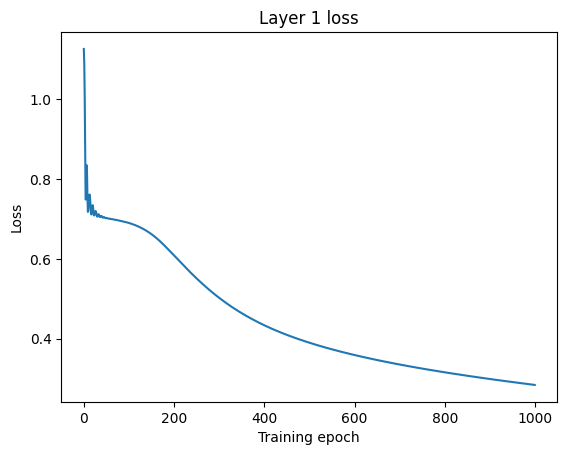

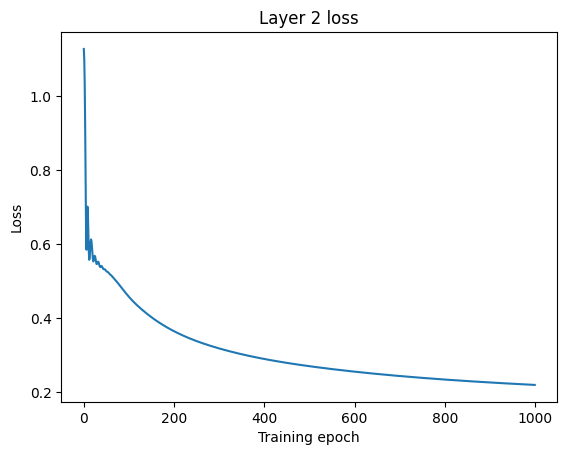

In [ ]:
losses = network.get_losses()
plot_loss(losses[0], 'Layer 1 loss')
plt.show()
plot_loss(losses[1], 'Layer 2 loss')
plt.show()

**Reporting the Test-Set Error**

In [ ]:
x_test, y_test = next(iter(test_loader))
x_test, y_test = x_test.to(device), y_test.to(device)

print('Test error:', 1.0 - network.predict(x_test).eq(y_test).float().mean().item())

Test error: 0.08240002393722534


# Unsupervised Forward-Forward on MNIST

**Generating Proper Masks**

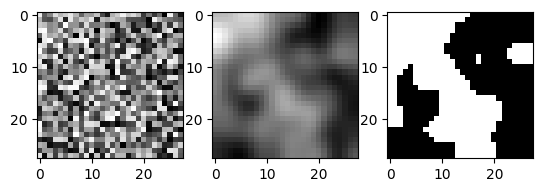

In [ ]:
noise = torch.rand(len(train_set),28,28,device=device)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(noise.cpu()[0].view(28,28))
blur = GaussianBlur(11, (2))
blured = blur(noise)
plt.subplot(1,3,2)
plt.imshow(blured.cpu()[0].view(28,28))
th = 0.5
mask = [blured >= th][0]*1
plt.subplot(1,3,3)
plt.imshow(mask.cpu()[0].view(28,28))
mask = mask.view(-1,28*28)

In [ ]:
x_train_pos, y_train = next(iter(train_loader))
x_train_pos, y_train = x_train_pos.to(device), y_train.to(device)
x_val_pos, y_val = next(iter(val_loader))
x_val_pos, y_val = x_val_pos.to(device), y_val.to(device)
x_test, y_test = next(iter(test_loader))
x_test, y_test = x_test.to(device), y_test.to(device)

**Generating Negative Data and Hybrid Data Using the Masks**

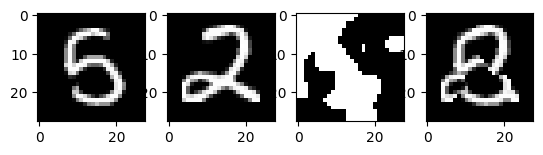

In [ ]:
idx = torch.randperm(x_train_pos.shape[0])
x_train_shuf = x_train_pos[idx]

idx = torch.randperm(x_val_pos.shape[0])
x_val_shuf = x_val_pos[idx]

x_train_neg = (x_train_pos * mask) + (x_train_shuf * (1-mask))
x_val_neg = (x_val_pos * mask[:len(x_val_pos)]) + (x_val_shuf * (1-mask[:len(x_val_pos)]))

plt.figure()
plt.subplot(1,4,1)
plt.imshow(x_train_pos.cpu()[0].view(28,28))
plt.subplot(1,4,2)
plt.imshow(x_train_shuf.cpu()[0].view(28,28))
plt.subplot(1,4,3)
plt.imshow(mask.cpu()[0].view(28,28))
plt.subplot(1,4,4)
plt.imshow(x_train_neg.cpu()[0].view(28,28))

**Defining Our FF Network**

In [ ]:
input_dimension = 28*28
unsup_network = FFNet([input_dimension, 300, 300])
unsup_network.train(x_train_pos, x_train_neg, x_val_pos, x_val_neg)

Layer 1 training in progress...
Layer 2 training in progress...
Training Completed!


**Visualizing the Validation Loss During**

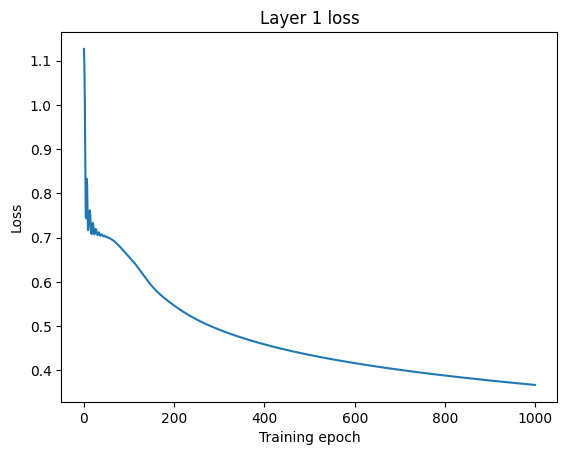

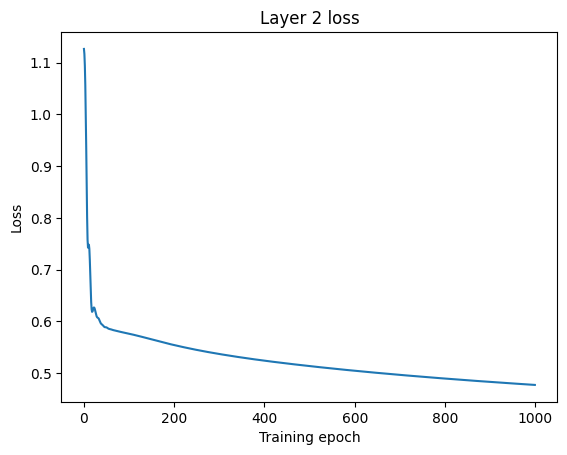

In [ ]:
losses = unsup_network.get_losses()
plot_loss(losses[0], 'Layer 1 loss')
plt.show()
plot_loss(losses[1], 'Layer 2 loss')
plt.show()

**What do the output of the FF network layers represent?**

**Answer:**
The FF netwrok helps to extract useful features out of the images. In order to be able to distinguish the difference between a true digit and a nonsense image, the FF network learns to pay attention to useful features which make a real digit and in this process it should learn features that are common in different digit images.

**Defining the Linear Classifier Layer**

In [ ]:
class Classifier(torch.nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.03)
        self.num_epochs = 150

    def forward(self, x):
        return torch.mm(x, self.weight.T) + self.bias.unsqueeze(0)

    def train(self, x_train, y_train, x_val, y_val):
        train_losses = []
        val_losses = []
        for i in range(self.num_epochs):
            self.optimizer.zero_grad()
            outputs = self.forward(x_train)
            loss = self.criterion(outputs, y_train)
            train_losses.append(loss.item())
            loss.backward()
            self.optimizer.step()

            outputs = self.forward(x_val)
            loss = self.criterion(outputs, y_val)
            val_losses.append(loss.item())

        return train_losses, val_losses

    def predict(self, inputs):
        outputs = self.forward(inputs)
        _, preds = torch.max(outputs.data, 1)

        return preds

**Why do we need a linear classifier?**

**Answer:**
The features that we talked about earlier are not enough for classifying the digits into the right classes, they just show some useful attributes which are common in different images. This important data should go under some proccess to be predicted as the right label out of 0 to 9. The linear classifier helps us with that.

**Visualizing the Train Loss and Validation Loss of the Linear Classifier**

<ipython-input-82-00595caf6fd5>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(activations.detach())


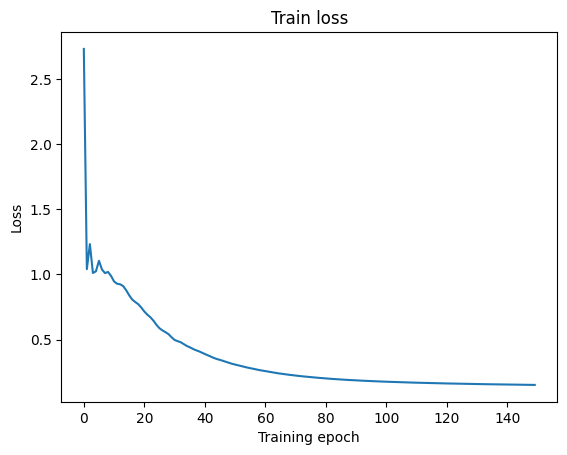

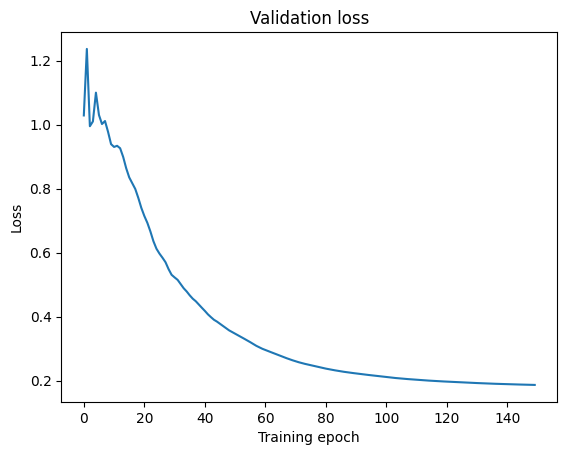

In [ ]:
train_acts = unsup_network.get_activations(x_train_pos)
output_layer = Classifier(train_acts.shape[1], 10, device=device)
val_acts = unsup_network.get_activations(x_val_pos)
train_losses, val_losses = output_layer.train(train_acts, y_train, val_acts, y_val)
plot_loss(train_losses, 'Train loss')
plt.show()
plot_loss(val_losses, 'Validation loss')
plt.show()

**Reporting the Test-Set Error**

In [ ]:
test_acts = unsup_network.get_activations(x_test)
print('Test error:', 1.0 - output_layer.predict(test_acts).eq(y_test).float().mean().item())

Test error: 0.05889999866485596


<ipython-input-82-00595caf6fd5>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(activations.detach())
